In [22]:
import numpy as np
from graphviz import Digraph
import math

In [23]:
class Value:
    def __init__ (self, data, _children = (), _op = "", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
        self.grad = 0
    
    def __add__ (self, other):
        if( isinstance(other, Value)):
            outVal = Value(self.data + other.data, (self, other), "+")
        else:
            outVal = Value(self.data + other, (self, Value(other)), "+")

        def _backward():
            self.grad += outVal.grad
            other.grad += outVal.grad
            
        outVal._backward = _backward
        return outVal
    
    def __mul__ (self, other):
        if(isinstance(other, Value)):
            outVal = Value(self.data * other.data, (self, other), "*")
        else:
            outVal = Value(self.data * other, (self,Value(other)), "*")
    
        outVal = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * outVal.grad
            other.grad += self.data * outVal.grad
        outVal._backward = _backward
        return outVal
    
    def __rmul__(self, other):
        return self*other
    
    def __radd__(self, other):
        return self + other

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def tanh(self):
        x = self.data
        tanhx = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        outVal = Value(tanhx, (self,), "tanh")
        def _backward():
            self.grad = (1-tanhx**2) * outVal.grad
        outVal._backward = _backward
        return outVal
    def backward(self):
        self.grad = 1

        ts = []
        visited = set()
        def build_toposort(n):
            if n not in visited:
                visited.add(n)
                for child in n._prev:
                    build_toposort(child)
                ts.append(n)
        build_toposort(self)
        ts = reversed(ts)
        for node in ts:
            node._backward()
        


a = Value(2, label="a")
b = Value(3, label="b")
c = a*b; c.label = "c"
c, c._prev, c._op

(Value(data=6), {Value(data=2), Value(data=3)}, '*')

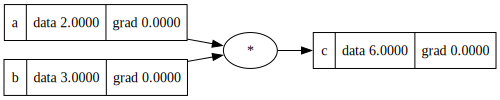

In [24]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s| data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

draw_dot(c)

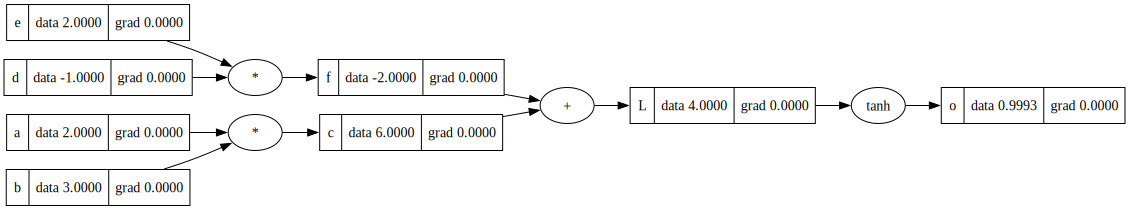

In [25]:
d = Value(-1, label = "d")
e = Value(2, label = "e")
f = d*e; f.label = "f"
L = f + c; L.label = "L"
o = L.tanh(); o.label = "o"
draw_dot(o)


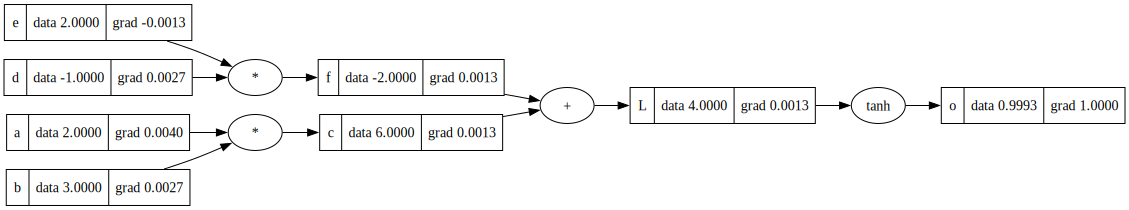

In [26]:
o.backward()
draw_dot(o)

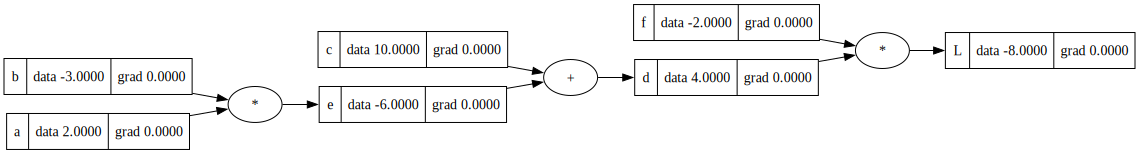

In [27]:
a = Value(2 ,label = "a")
b = Value(-3, label = "b")
c = Value(10, label = "c")
e = a*b; e.label = "e"
d = e+c; d.label = "d"
f = Value(-2, label = "f")
L = d * f; L.label = "L"
draw_dot(L)

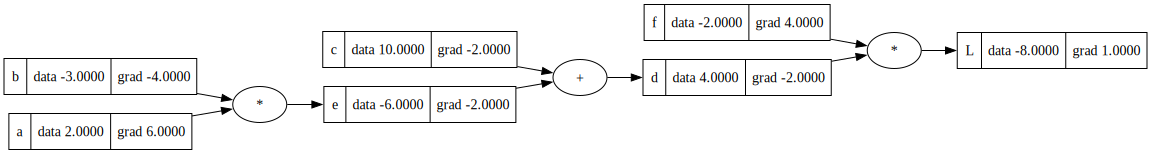

In [28]:
L.backward()
draw_dot(L)

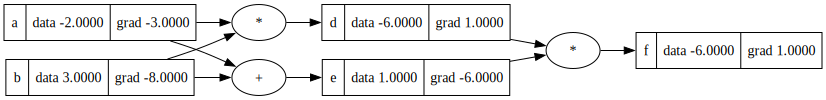

In [29]:
a = Value(-2.0, label = "a")
b = Value(3.0, label = "b")
d = a*b; d.label = "d"
e = a+b; e.label = "e"
f = d*e; f.label = "f"
f.backward()
draw_dot(f)

In [30]:
import random
class Neuron:
    def __init__(self, num_inputs):
        self.weights = [Value(random.uniform(-1,1)) for _ in range(num_inputs)]
        self.bias = Value(random.uniform(-1,1))
    def __call__(self, x):
        a = sum([x*w for x,w in zip(self.weights, x)]) + self.bias
        o = a.tanh()
        return o

t = [Value(2.0),Value(3.0)]
n = Neuron(2)
n(t)



Value(data=0.48049731782027666)